# Название проекта: Определение жанра по изображению обложки музыкального диска

**Описание проекта**
<br>Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки

**Цель проекта**
<br>Необходимо разработать модель, которая определит жанр музыкального альбома по изображению его обложки

**Метрики**: `Accuracy`, `Precision`, `Recall`, `F1`

**Данные**
<br>Изображения в формате PNG, упакованные в zip-архивы. 
<br>Имя архива соответствует музыкальному жанру.
<br>Каждый zip-архив содержит папку с изображениями музыкальных обложек соответствующего жанра.

**Дополнительные задачи**
- **Кластеризация**: исследовать, какие жанры лучше выделяются на фоне других, а какие – трудноразделимы.
- **API MusicBrainz**: расширение датасета новыми изображениями. Можно расширить список жанров и использовать обратную сторону обложки.
- **OCR + NLP**: извлечь текст из изображения и обогатить решение применением NLP.
- **Создание рекомендательной системы** в миниатюре, опираясь на изображения.
- **Streamlit**: оформить классификатор жанров или рекомендательную систему в виде веб-приложения.

**Ход исследования**
- Ознакомление с данными;
- Предварительная обработка данных;
- Определение целевой метрики;
- Подготовка данных для baseline-модели;
- Создание baseline-модели;
- Расчет метрик;
- Подготовка данных для нейронной сети;
- Обучение нейронной сети;
- Расчет и сравнение метрик;
- Анализ финальной модели;
- Исследование/решение дополнительных задач;
- Подготовка отчета по исследованию.

**Основные метрики**
- `ROC-AUC`, `F1`

Настройка среды

In [20]:
# !pip install pandas
# !pip install seaborn

In [36]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

Установка глобальных переменных

In [49]:
RANDOM_STATE = 42
DATA_PATH = 'data'
ASSETS_DIR = 'assets'

## Знакомство с данными

In [50]:
# пустой список для хранения данных
data = []

# список жанров
genres = os.listdir(DATA_PATH)

# цикл по каждой папке (жанру)
for genre in genres:
    genre_path = os.path.join(DATA_PATH, genre)
    
    # список файлов (изображений альбомов) в текущей папке (жанре)
    album_images = os.listdir(genre_path)
    
    # цикл по каждому изображению альбома
    for image_name in album_images:
        # добавление данных в список
        data.append({'image_name': image_name, 'genre_name': genre})

# датафрейм из списка данных
df = pd.DataFrame(data)

In [51]:
print(f"количество уникальных жанров: {df['genre_name'].nunique()}")
print()
print('вывод общей информации:')
df.info()
print()
print("первые пять строк датафрейма:")
df.head()

количество уникальных жанров: 10

вывод общей информации:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7800 entries, 0 to 7799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  7800 non-null   object
 1   genre_name  7800 non-null   object
dtypes: object(2)
memory usage: 122.0+ KB

первые пять строк датафрейма:


,image_name,genre_name
0,8fefae6e-bf75-4b5e-acd6-9ba483009534.png,black metal
1,f7df5071-6f2d-4593-a9b1-34fe8ed971c1.png,black metal
2,1247b021-ad19-42d5-bbe0-b950f75b95c5.png,black metal
3,03b3ed83-3334-4906-a678-7b90e256d363.png,black metal
4,1b966d7f-53cf-42fd-a884-cc86aa1ce7a2.png,black metal


### Выводы и наблюдения:
- создан датафрейм, состоящий из названий обложек и целевой переменной (название жанра);
- количество представленных изображений - 7800 штук;
- количество уникальных жанров - 10.

## EDA

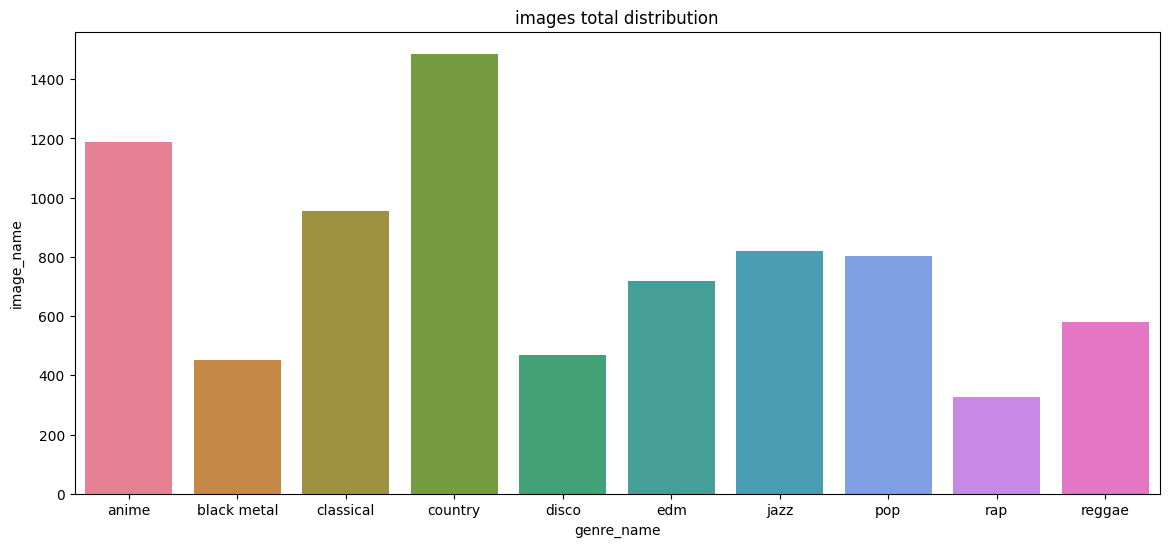

In [29]:
plt.figure(figsize=(14, 6))
df_agg = df.groupby('genre_name').agg({'image_name': 'count'}).reset_index()

sns.barplot(data=df_agg,
            x='genre_name',
            y='image_name',
            hue='genre_name',
            palette=sns.color_palette("husl", len(df_agg)))

plt.title(f"images total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'images total distribution.png'))
plt.show()

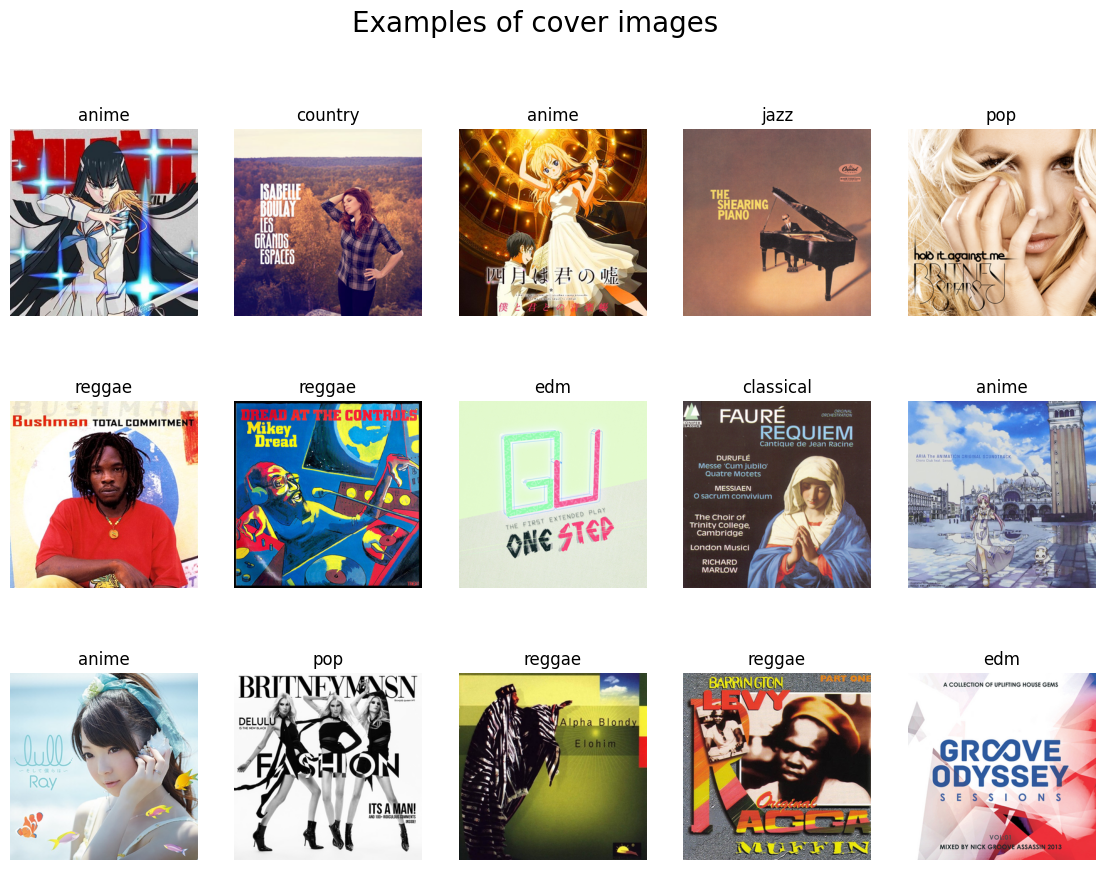

In [52]:
fig, axs = plt.subplots(3, 5, figsize=(14, 10))
fig.suptitle('Examples of cover images', fontsize=20)
for i, (index, row) in enumerate(df.sample(n=15).iterrows()):
    image_path = os.path.join(DATA_PATH, row['genre_name'], row['image_name'])
    image = Image.open(image_path)
    
    ax = axs[i // 5, i % 5]
    ax.imshow(image)
    ax.axis('off')
    ax.set_title(row['genre_name'], fontsize=12)
plt.savefig(os.path.join(ASSETS_DIR, 'Examples of cover images.png'))
plt.show()

### Выводы и наблюдения:
- наименьшее количество образцов представлено в жанре `rap`;
- больше всего изображений обложек из жанра `country`;
- судя по образцам изображений, дополнительных манипуляций над ними не требуется.